<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#数据管道Dataset" data-toc-modified-id="数据管道Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>数据管道<code>Dataset</code></a></span><ul class="toc-item"><li><span><a href="#创建Dataset" data-toc-modified-id="创建Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>创建<code>Dataset</code></a></span></li><li><span><a href="#数据处理" data-toc-modified-id="数据处理-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>数据处理</a></span></li><li><span><a href="#提升性能" data-toc-modified-id="提升性能-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>提升性能</a></span></li></ul></li><li><span><a href="#创建特征" data-toc-modified-id="创建特征-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>创建特征</a></span></li></ul></div>

# 数据管道`Dataset`
- 当需要训练的数据很大，例如超过10G，无法一次载入内存，那么通常需要在训练的过程中分批逐渐读入。
- 使用 `tf.data` API 可以构建数据输入管道，轻松处理大量的数据，不同的数据格式，以及不同的数据转换。

In [1]:
import tensorflow as tf
import numpy as np
from sklearn import datasets

## 创建`Dataset`

In [3]:
# Numpy array
iris = datasets.load_iris()
print(type(iris['data']), type(iris['target']))
ds1 = tf.data.Dataset.from_tensor_slices((iris["data"], iris["target"]))
for features, label in ds1.take(2):
    print(features, label)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
tf.Tensor([5.1 3.5 1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.9 3.  1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)


In [5]:
# Pandas DataFrame
import pandas as pd
dfiris = pd.DataFrame(iris["data"], columns=iris.feature_names)
print(dfiris.head(2))

ds2 = tf.data.Dataset.from_tensor_slices(
    (dfiris.to_dict("list"), iris["target"]))
for features, label in ds2.take(2):
    print(features, label)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
{'sepal length (cm)': <tf.Tensor: id=51, shape=(), dtype=float32, numpy=5.1>, 'sepal width (cm)': <tf.Tensor: id=52, shape=(), dtype=float32, numpy=3.5>, 'petal length (cm)': <tf.Tensor: id=49, shape=(), dtype=float32, numpy=1.4>, 'petal width (cm)': <tf.Tensor: id=50, shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)
{'sepal length (cm)': <tf.Tensor: id=56, shape=(), dtype=float32, numpy=4.9>, 'sepal width (cm)': <tf.Tensor: id=57, shape=(), dtype=float32, numpy=3.0>, 'petal length (cm)': <tf.Tensor: id=54, shape=(), dtype=float32, numpy=1.4>, 'petal width (cm)': <tf.Tensor: id=55, shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)


In [10]:
# Python generator
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    "datasets/cifar2/test",
    target_size=(32, 32),
    batch_size=20,
    class_mode='binary')
classdict = image_generator.class_indices
print(classdict)


def generator():
    for features, label in image_generator:
        yield (features, label)


ds3 = tf.data.Dataset.from_generator(generator,
                                     output_types=(tf.float32, tf.int32))



Found 2000 images belonging to 2 classes.
{'airplane': 0, 'automobile': 1}


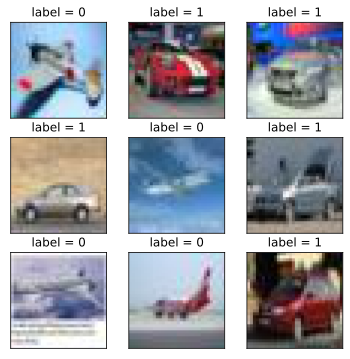

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(6, 6))
for i, (img, label) in enumerate(ds3.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d" % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [13]:
# csv文件内容
ds4 = tf.data.experimental.make_csv_dataset(
    file_pattern=['datasets/titanic/train.csv', 'datasets/titanic/test.csv'],
    batch_size=3,
    label_name="Survived",
    na_value="",
    num_epochs=1,
    ignore_errors=True)

for data, label in ds4.take(1):
    print(data, label)

OrderedDict([('PassengerId', <tf.Tensor: id=341, shape=(3,), dtype=int32, numpy=array([254, 728, 349], dtype=int32)>), ('Pclass', <tf.Tensor: id=342, shape=(3,), dtype=int32, numpy=array([3, 3, 3], dtype=int32)>), ('Name', <tf.Tensor: id=339, shape=(3,), dtype=string, numpy=
array([b'Lobb, Mr. William Arthur', b'Mannion, Miss. Margareth',
       b'Coutts, Master. William Loch "William"'], dtype=object)>), ('Sex', <tf.Tensor: id=343, shape=(3,), dtype=string, numpy=array([b'male', b'female', b'male'], dtype=object)>), ('Age', <tf.Tensor: id=335, shape=(3,), dtype=float32, numpy=array([30.,  0.,  3.], dtype=float32)>), ('SibSp', <tf.Tensor: id=344, shape=(3,), dtype=int32, numpy=array([1, 0, 1], dtype=int32)>), ('Parch', <tf.Tensor: id=340, shape=(3,), dtype=int32, numpy=array([0, 0, 1], dtype=int32)>), ('Ticket', <tf.Tensor: id=345, shape=(3,), dtype=string, numpy=array([b'A/5. 3336', b'36866', b'C.A. 37671'], dtype=object)>), ('Fare', <tf.Tensor: id=338, shape=(3,), dtype=float32, nump

In [14]:
# 从文本文件
ds5 = tf.data.TextLineDataset(
    filenames=['datasets/titanic/train.csv', 'datasets/titanic/test.csv'
               ]).skip(1)
for line in ds5.take(2):
    print(line)

tf.Tensor(b'493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5,C30,S', shape=(), dtype=string)
tf.Tensor(b'53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C', shape=(), dtype=string)


In [15]:
# 从文件路径
ds6 = tf.data.Dataset.list_files("datasets/cifar2/train/*/*.jpg")
for file in ds6.take(2):
    print(file)

tf.Tensor(b'datasets/cifar2/train/airplane/4059.jpg', shape=(), dtype=string)
tf.Tensor(b'datasets/cifar2/train/automobile/3004.jpg', shape=(), dtype=string)


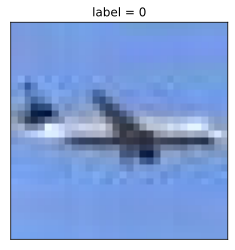

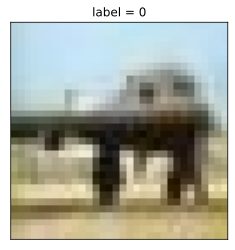

In [16]:
from matplotlib import pyplot as plt


def load_image(img_path, size=(32, 32)):
    label = 1 if tf.strings.regex_full_match(img_path,
                                             ".*/automobile/.*") else 0
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)  #注意此处为jpeg格式
    img = tf.image.resize(img, size)
    return (img, label)


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
for i, (img, label) in enumerate(ds6.map(load_image).take(2)):
    plt.figure(i)
    plt.imshow((img / 255.0).numpy())
    plt.title("label = %d" % label)
    plt.xticks([])
    plt.yticks([])

In [17]:
# 从tfrecords文件构建
import os
import numpy as np


# inpath：原始数据路径 
# outpath:TFRecord文件输出路径
def create_tfrecords(inpath, outpath):
    writer = tf.io.TFRecordWriter(outpath)
    dirs = os.listdir(inpath)
    for index, name in enumerate(dirs):
        class_path = inpath + "/" + name + "/"
        for img_name in os.listdir(class_path):
            img_path = class_path + img_name
            img = tf.io.read_file(img_path)
            #img = tf.image.decode_image(img)
            #img = tf.image.encode_jpeg(img) #统一成jpeg格式压缩
            example = tf.train.Example(features=tf.train.Features(
                feature={
                    'label':
                    tf.train.Feature(int64_list=tf.train.Int64List(
                        value=[index])),
                    'img_raw':
                    tf.train.Feature(bytes_list=tf.train.BytesList(
                        value=[img.numpy()]))
                }))
            writer.write(example.SerializeToString())
    writer.close()


create_tfrecords("datasets/cifar2/test/", "datasets/cifar2_test.tfrecords/")

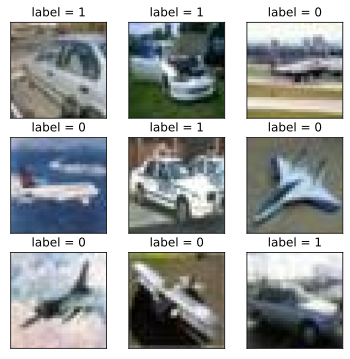

In [18]:
from matplotlib import pyplot as plt


def parse_example(proto):
    description = {
        'img_raw': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(proto, description)
    img = tf.image.decode_jpeg(example["img_raw"])  #注意此处为jpeg格式
    img = tf.image.resize(img, (32, 32))
    label = example["label"]
    return (img, label)


ds7 = tf.data.TFRecordDataset("datasets/cifar2_test.tfrecords").map(
    parse_example).shuffle(3000)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(6, 6))
for i, (img, label) in enumerate(ds7.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow((img / 255.0).numpy())
    ax.set_title("label = %d" % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## 数据处理
`Dataset`包含了非常丰富的数据转换功能。

- `map`: 将转换函数映射到数据集每一个元素。

- `flat_map`: 将转换函数映射到数据集的每一个元素，并将嵌套的`Dataset`压平。

- `interleave`: 效果类似`flat_map`,但可以将不同来源的数据夹在一起。

- `filter`: 过滤掉某些元素。

- `zip`: 将两个长度相同的`Dataset`横向铰合。

- `concatenate`: 将两个`Dataset`纵向连接。

- `reduce`: 执行归并操作。

- `batch` : 构建批次，每次放一个批次。比原始数据增加一个维度。 其逆操作为unbatch。

- `padded_batch`: 构建批次，类似`batch`, 但可以填充到相同的形状。

- `window` :构建滑动窗口，返回`Dataset of Dataset`.

- `shuffle`: 数据顺序重排。

- `repeat`: 重复数据若干次，不带参数时，重复无数次。

- `shard`: 采样，从某个位置开始隔固定距离采样一个元素。

- `take`: 采样，从开始位置取前几个元素。


In [15]:
ds = tf.data.Dataset.from_tensor_slices(
    ["hello world", "hello China", "hello Beijing"])
ds_map = ds.map(lambda x: tf.strings.split(x, " "))
for x in ds_map:
    print(x)

tf.Tensor([b'hello' b'world'], shape=(2,), dtype=string)
tf.Tensor([b'hello' b'China'], shape=(2,), dtype=string)
tf.Tensor([b'hello' b'Beijing'], shape=(2,), dtype=string)


In [16]:
#flat_map:将转换函数映射到数据集的每一个元素，并将嵌套的Dataset压平。

ds = tf.data.Dataset.from_tensor_slices(
    ["hello world", "hello China", "hello Beijing"])
ds_flatmap = ds.flat_map(
    lambda x: tf.data.Dataset.from_tensor_slices(tf.strings.split(x, " ")))
for x in ds_flatmap:
    print(x)

tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'world', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'China', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'Beijing', shape=(), dtype=string)


In [17]:
# interleave: 效果类似flat_map,但可以将不同来源的数据夹在一起。

ds = tf.data.Dataset.from_tensor_slices(
    ["hello world", "hello China", "hello Beijing"])
ds_interleave = ds.interleave(
    lambda x: tf.data.Dataset.from_tensor_slices(tf.strings.split(x, " ")))
for x in ds_interleave:
    print(x)

tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'world', shape=(), dtype=string)
tf.Tensor(b'China', shape=(), dtype=string)
tf.Tensor(b'Beijing', shape=(), dtype=string)


In [18]:
# filter:过滤掉某些元素。

ds = tf.data.Dataset.from_tensor_slices(
    ["hello world", "hello China", "hello Beijing"])
#找出含有字母a或B的元素
ds_filter = ds.filter(lambda x: tf.strings.regex_full_match(x, ".*[a|B].*"))
for x in ds_filter:
    print(x)

tf.Tensor(b'hello China', shape=(), dtype=string)
tf.Tensor(b'hello Beijing', shape=(), dtype=string)


In [19]:
# zip:将两个长度相同的Dataset横向铰合。

ds1 = tf.data.Dataset.range(0, 3)
ds2 = tf.data.Dataset.range(3, 6)
ds3 = tf.data.Dataset.range(6, 9)
ds_zip = tf.data.Dataset.zip((ds1, ds2, ds3))
for x, y, z in ds_zip:
    print(x.numpy(), y.numpy(), z.numpy())

0 3 6
1 4 7
2 5 8


In [20]:
# condatenate:将两个Dataset纵向连接。

ds1 = tf.data.Dataset.range(0, 3)
ds2 = tf.data.Dataset.range(3, 6)
ds_concat = tf.data.Dataset.concatenate(ds1, ds2)
for x in ds_concat:
    print(x)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)


In [21]:
# reduce:执行归并操作。

ds = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5.0])
result = ds.reduce(0.0, lambda x, y: tf.add(x, y))
result

<tf.Tensor: id=4814, shape=(), dtype=float32, numpy=15.0>

In [22]:
# batch:构建批次，每次放一个批次。比原始数据增加一个维度。 其逆操作为unbatch。

ds = tf.data.Dataset.range(12)
ds_batch = ds.batch(4)
for x in ds_batch:
    print(x)

tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int64)
tf.Tensor([ 8  9 10 11], shape=(4,), dtype=int64)


In [23]:
# padded_batch:构建批次，类似batch, 但可以填充到相同的形状。

elements = [[1, 2], [3, 4, 5], [6, 7], [8]]
ds = tf.data.Dataset.from_generator(lambda: iter(elements), tf.int32)

ds_padded_batch = ds.padded_batch(2, padded_shapes=[
    4,
])
for x in ds_padded_batch:
    print(x)

tf.Tensor(
[[1 2 0 0]
 [3 4 5 0]], shape=(2, 4), dtype=int32)
tf.Tensor(
[[6 7 0 0]
 [8 0 0 0]], shape=(2, 4), dtype=int32)


In [24]:
#window:构建滑动窗口，返回Dataset of Dataset.

ds = tf.data.Dataset.range(12)
#window返回的是Dataset of Dataset,可以用flat_map压平
ds_window = ds.window(
    3, shift=1).flat_map(lambda x: x.batch(3, drop_remainder=True))
for x in ds_window:
    print(x)

    3, shift=1).flat_map(lambda x: x.batch(3, drop_remainder=True))

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
    3, shift=1).flat_map(lambda x: x.batch(3, drop_remainder=True))

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
tf.Tensor([0 1 2], shape=(3,), dtype=int64)
tf.Tensor([1 2 3], shape=(3,), dtype=int64)
tf.Tensor([2 3 4], shape=(3,), dtype=int64)
tf.Tensor([3 4 5], shape=(3,), dtype=int64)
tf.Tensor([4 5 6], shape=(3,), dtype=int64)
tf.Tensor([5 6 7], shape=(3,), dtype=int64)
tf.Tensor([6 7 8], shape=(3,), dtype=int64)
tf.Tensor([7 8 9], shape=(3,), dtype=int64)
tf.Tensor([ 8  9 10], shape=(3,), dtype=int64)
tf.Tensor([ 9 10 11], shape=(3,), dtype=int64)


In [25]:
#shuffle:数据顺序重排。

ds = tf.data.Dataset.range(12)
ds_shuffle = ds.shuffle(buffer_size=5)
for x in ds_shuffle:
    print(x)

tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(11, shape=(), dtype=int64)


In [27]:
#shard:采样，从某个位置开始隔固定距离采样一个元素。

ds = tf.data.Dataset.range(12)
ds_shard = ds.shard(3, index=1)

for x in ds_shard:
    print(x)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)


In [30]:
#take:采样，从开始位置取前几个元素。
ds = tf.data.Dataset.range(12)
ds_take = ds.take(3)

for x in ds_take:
    print(x)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


## 提升性能
模型训练的耗时主要来自于两个部分，一部分来自数据准备，另一部分来自参数迭代。
- 参数迭代过程的耗时通常依赖于GPU来提升。
- 而数据准备过程的耗时则可以通过构建高效的数据管道进行提升。

以下是一些构建高效数据管道的建议：
- 使用 `prefetch` 方法让数据准备和参数迭代两个过程相互并行。
- 使用 `interleave` 方法可以让数据读取过程多进程执行,并将不同来源数据夹在一起。
- 使用 `map` 时设置`num_parallel_calls` 让数据转换过程多进程执行。
- 使用 `cache` 方法让数据在第一个`epoch`后缓存到内存中，仅限于数据集不大的情形。
- 使用 `map转换时`，先`batch`, 然后采用向量化的转换方法对每个`batch`进行转换。


In [19]:
# prefetch 让数据准备和参数迭代两个过程相互并行

import tensorflow as tf

# 辅助函数，打印时间
@tf.function
def printbar():
    ts = tf.timestamp()
    today_ts = ts % (24 * 60 * 60)

    hour = tf.cast(today_ts // 3600 + 8, tf.int32) % tf.constant(24)
    minite = tf.cast((today_ts % 3600) // 60, tf.int32)
    second = tf.cast(tf.floor(today_ts % 60), tf.int32)

    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}", m)) == 1:
            return (tf.strings.format("0{}", m))
        else:
            return (tf.strings.format("{}", m))

    timestring = tf.strings.join(
        [timeformat(hour),
         timeformat(minite),
         timeformat(second)],
        separator=":")
    tf.print("==========" * 8, end="")
    tf.print(timestring)

In [20]:
import time


def generator():
    for i in range(10):
        # 假设每次准备数据需要2s
        time.sleep(2)
        yield i


ds = tf.data.Dataset.from_generator(generator, output_types=tf.int32)


def train_step():
    # 假设每一步训练需要1s
    time.sleep(1)

In [21]:
# 普通训练时间 10*2+10*1 = 30
printbar()
tf.print(tf.constant("start training..."))

for x in ds:
    train_step()
    
printbar()
tf.print(tf.constant("end training..."))

================================================================================16:33:18
start training...
================================================================================16:33:48
end training...


In [23]:
# 使用 prefetch 方法让数据准备和参数迭代两个过程相互并行。

# 训练过程预计耗时 max(10*2,10*1) = 20s

printbar()
tf.print(tf.constant("start training..."))

for x in ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE):
    train_step()
    
printbar()
tf.print(tf.constant("end training..."))

================================================================================16:35:21
start training...
================================================================================16:35:42
end training...


In [26]:
# 使用 interleave 方法可以让数据读取过程多进程执行,并将不同来源数据夹在一起

ds_files = tf.data.Dataset.list_files("datasets/titanic/*.csv")
ds = ds_files.flat_map(lambda x: tf.data.TextLineDataset(x).skip(1))
for line in ds.take(4):
    print(line)

tf.Tensor(b'181,0,3,"Sage, Miss. Constance Gladys",female,,8,2,CA. 2343,69.55,,S', shape=(), dtype=string)
tf.Tensor(b'405,0,3,"Oreskovic, Miss. Marija",female,20.0,0,0,315096,8.6625,,S', shape=(), dtype=string)
tf.Tensor(b'635,0,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.9,,S', shape=(), dtype=string)
tf.Tensor(b'701,1,1,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",female,18.0,1,0,PC 17757,227.525,C62 C64,C', shape=(), dtype=string)


In [27]:
ds_files = tf.data.Dataset.list_files("datasets/titanic/*.csv")
ds = ds_files.interleave(lambda x: tf.data.TextLineDataset(x).skip(1))
for line in ds.take(8):
    print(line)

tf.Tensor(b'493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5,C30,S', shape=(), dtype=string)
tf.Tensor(b'181,0,3,"Sage, Miss. Constance Gladys",female,,8,2,CA. 2343,69.55,,S', shape=(), dtype=string)
tf.Tensor(b'53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C', shape=(), dtype=string)
tf.Tensor(b'405,0,3,"Oreskovic, Miss. Marija",female,20.0,0,0,315096,8.6625,,S', shape=(), dtype=string)
tf.Tensor(b'388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'635,0,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.9,,S', shape=(), dtype=string)
tf.Tensor(b'192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'701,1,1,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",female,18.0,1,0,PC 17757,227.525,C62 C64,C', shape=(), dtype=string)


In [28]:
# 使用 map 时设置num_parallel_calls 让数据转换过程多进行执行。

ds = tf.data.Dataset.list_files("datasets/cifar2/train/*/*.jpg")


def load_image(img_path, size=(32, 32)):
    label = 1 if tf.strings.regex_full_match(img_path,
                                             ".*/automobile/.*") else 0
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)  #注意此处为jpeg格式
    img = tf.image.resize(img, size)
    return (img, label)

In [29]:
#单进程转换
printbar()
tf.print(tf.constant("start transformation..."))

ds_map = ds.map(load_image)
for _ in ds_map:
    pass

printbar()
tf.print(tf.constant("end transformation..."))

================================================================================16:39:11
start transformation...
================================================================================16:39:13
end transformation...


In [30]:
#多进程转换
printbar()
tf.print(tf.constant("start parallel transformation..."))

ds_map_parallel = ds.map(load_image,
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
for _ in ds_map_parallel:
    pass

printbar()
tf.print(tf.constant("end parallel transformation..."))

================================================================================16:39:34
start parallel transformation...
================================================================================16:39:35
end parallel transformation...


In [31]:
# 使用 cache 方法让数据在第一个epoch后缓存到内存中，仅限于数据集不大情形。

import time


# 模拟数据准备
def generator():
    for i in range(5):
        #假设每次准备数据需要2s
        time.sleep(2)
        yield i


ds = tf.data.Dataset.from_generator(generator, output_types=(tf.int32))


# 模拟参数迭代
def train_step():
    #假设每一步训练需要0s
    pass


# 训练过程预计耗时 (5*2+5*0)*3 = 30s
printbar()
tf.print(tf.constant("start training..."))

for epoch in tf.range(3):
    for x in ds:
        train_step()
        
    printbar()
    tf.print("epoch =", epoch, " ended")
    
printbar()
tf.print(tf.constant("end training..."))

================================================================================16:40:34
start training...
================================================================================16:40:44
epoch = 0  ended
================================================================================16:40:54
epoch = 1  ended
================================================================================16:41:04
epoch = 2  ended
================================================================================16:41:04
end training...


In [32]:
import time


# 模拟数据准备
def generator():
    for i in range(5):
        #假设每次准备数据需要2s
        time.sleep(2)
        yield i


# 使用 cache 方法让数据在第一个epoch后缓存到内存中，仅限于数据集不大情形。
ds = tf.data.Dataset.from_generator(generator, output_types=(tf.int32)).cache()


# 模拟参数迭代
def train_step():
    #假设每一步训练需要0s
    time.sleep(0)


# 训练过程预计耗时 (5*2+5*0)+(5*0+5*0)*2 = 10s
printbar()
tf.print(tf.constant("start training..."))
for epoch in tf.range(3):
    for x in ds:
        train_step()
    printbar()
    tf.print("epoch =", epoch, " ended")
printbar()
tf.print(tf.constant("end training..."))

================================================================================16:41:12
start training...
================================================================================16:41:22
epoch = 0  ended
================================================================================16:41:22
epoch = 1  ended
================================================================================16:41:22
epoch = 2  ended
================================================================================16:41:22
end training...


In [35]:
# 使用 map转换时，先batch, 然后采用向量化的转换方法对每个batch进行转换。

#先map后batch
ds = tf.data.Dataset.range(1000000)
ds_map_batch = ds.map(lambda x: x**2).batch(20)

printbar()
tf.print(tf.constant("start scalar transformation..."))

for x in ds_map_batch:
    pass

printbar()
tf.print(tf.constant("end scalar transformation..."))

================================================================================16:44:22
start scalar transformation...
================================================================================16:44:35
end scalar transformation...


In [36]:
#先batch后map
ds = tf.data.Dataset.range(1000000)
ds_batch_map = ds.batch(20).map(lambda x:x**2)

printbar()
tf.print(tf.constant("start vector transformation..."))

for x in ds_batch_map:
    pass

printbar()
tf.print(tf.constant("end vector transformation..."))

================================================================================16:44:41
start vector transformation...
================================================================================16:44:44
end vector transformation...


# 创建特征
- 将类别特征转换为`one-hot`编码，将连续特征构建分桶特征，以及多个特征生成交叉特征等等。
- 特征列通常用于对结构化数据实施特征工程时候使用，图像或者文本数据一般不会用到特征列。
- `tf.feature_column`:
    - `numeric_column` 数值列，最常用。
    - `bucketized_column` 分桶列，由数值列生成，可以由一个数值列出多个特征，`one`-hot编码。
    - `categorical_column_with_identity` 分类标识列，`one-hot`编码，相当于分桶列每个桶为1个整数的情况。
    - `categorical_column_with_vocabulary_list` 分类词汇列，`one-hot`编码，由list指定词典。
    - `categorical_column_with_vocabulary_file` 分类词汇列，由文件file指定词典。
    - `categorical_column_with_hash_bucket` 哈希列，整数或词典较大时采用。
    - `indicator_column` 指标列，由`Categorical Column`生成，`one-hot`编码
    - `embedding_column` 嵌入列，由`Categorical Column`生成，嵌入矢量分布参数需要学习。嵌入矢量维数建议取类别数量的 4 次方根。
    - `crossed_column` 交叉列，可以由除`categorical_column_with_hash_bucket`的任意分类列构成。


In [38]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [39]:
def printlog(info):
    nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print("\n" + "======" * 8 + "%s" % nowtime)
    print(info + "...\n\n")

In [40]:
# 一、构建数据管道
printlog("step 1: prepare dataset...")

dftrain_raw = pd.read_csv("datasets/titanic/train.csv")
dftest_raw = pd.read_csv("datasets/titanic/test.csv")

dfraw = pd.concat([dftrain_raw, dftest_raw])


def prepare_dfdata(dfraw):
    dfdata = dfraw.copy()
    dfdata.columns = [x.lower() for x in dfdata.columns]
    dfdata = dfdata.rename(columns={'survivied': 'label'})
    dfdata = dfdata.drop(['passengerid', 'name'], axis=1)
    for col, dtype in dict(dfdata.dtypes).items():
        # 判断是否包含缺失值
        if dfdata[col].hasnans:
            # 添加标识是否缺失列
            dfdata[col + '_nan'] = pd.isna(dfdata[col]).astype('int32')
            # 填充
            if dtype not in [np.object, np.str, np.unicode]:
                dfdata[col].fillna(dfdata[col].mean(), inplace=True)
            else:
                dfdata[col].fillna('', inplace=True)
    return (dfdata)


dfdata = prepare_dfdata(dfraw)
dftrain = dfdata.iloc[0:len(dftrain_raw), :]
dftest = dfdata.iloc[len(dftrain_raw):, :]


# 从 dataframe 导入数据
def df_to_dataset(df, shuffle=True, batch_size=32):
    dfdata = df.copy()
    if 'label' not in dfdata.columns:
        ds = tf.data.Dataset.from_tensor_slices(dfdata.to_dict(orient='list'))
    else:
        labels = dfdata.pop('label')
        ds = tf.data.Dataset.from_tensor_slices(
            (dfdata.to_dict(orient='list'), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dfdata))
    ds = ds.batch(batch_size)
    return ds


ds_train = df_to_dataset(dftrain)
ds_test = df_to_dataset(dftest)


================================================2020-04-06 17:03:17
step 1: prepare dataset......




In [41]:
# 二，定义特征列
#================================================================================
printlog("step2: make feature columns...")

feature_columns = []

# 数值列
for col in ['age', 'fare', 'parch', 'sibsp'
            ] + [c for c in dfdata.columns if c.endswith('_nan')]:
    feature_columns.append(tf.feature_column.numeric_column(col))

# 分桶列
age = tf.feature_column.numeric_column('age')
age_buckets = tf.feature_column.bucketized_column(
    age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# 类别列
# 注意：所有的Catogorical Column类型最终都要通过indicator_column转换成Dense Column类型才能传入模型！！
sex = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(
        key='sex', vocabulary_list=["male", "female"]))
feature_columns.append(sex)

pclass = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(
        key='pclass', vocabulary_list=[1, 2, 3]))
feature_columns.append(pclass)

ticket = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_hash_bucket('ticket', 3))
feature_columns.append(ticket)

embarked = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(
        key='embarked', vocabulary_list=['S', 'C', 'B']))
feature_columns.append(embarked)

# 嵌入列
cabin = tf.feature_column.embedding_column(
    tf.feature_column.categorical_column_with_hash_bucket('cabin', 32), 2)
feature_columns.append(cabin)

# 交叉列
pclass_cate = tf.feature_column.categorical_column_with_vocabulary_list(
    key='pclass', vocabulary_list=[1, 2, 3])

crossed_feature = tf.feature_column.indicator_column(
    tf.feature_column.crossed_column([age_buckets, pclass_cate],
                                     hash_bucket_size=15))

feature_columns.append(crossed_feature)


================================================2020-04-06 17:03:53
step2: make feature columns......




In [42]:
# 三，定义模型
#================================================================================
printlog("step3: define model...")

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    layers.DenseFeatures(
        feature_columns),  #将特征列放入到tf.keras.layers.DenseFeatures中!!!
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


================================================2020-04-06 17:04:16
step3: define model......




In [43]:
# 四，训练模型
#================================================================================
printlog("step4: train model...")

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_test, epochs=10)


================================================2020-04-06 17:04:25
step4: train model......


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Epoch 1/10
      1/Unknown - 0s 109ms/step

IndexError: list index out of range

In [ ]:
# 五，评估模型
#================================================================================
printlog("step5: eval model...")

model.summary()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt


def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])
    plt.show()


plot_metric(history, "accuracy")